# Extract BPP of mature sequence of miRNAs in Lee _et al._ 2011

This notebook describes how the pre-miRNA structures were obtained from [mirBase](https://mirbase.org/) and parsed to isolate the mature sequences with true base pairings. The sequences were then used to create custom FASTA files for use in [RNACofold](https://www.tbi.univie.ac.at/RNA/RNAcofold.1.html) and the base-pair binding probabilit (BPP) extracted based on the mirBase structure.

## Obtaining structures from mirBase

### Setup

In [1]:
#prepare environment
import requests
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import mirna as mr
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.stats as st

### Utils

In [2]:
def url_generator_mirbase(accession):
    """
    Function to automatically generate urls for scraping mirbase
    
    Args:
    accession (list): mirbase accession number for target miRNA OR miRNA name
    
    Returns:
    urls (list):      list of mirbase urls for target miRNA
    """
    
    mirbase = 'https://www.mirbase.org/hairpin/'
    urls = []
    for i in range(len(accession)):
        urls.append(mirbase+accession[i])
        
    return urls

In [3]:
def return_structure(accessions):
    """
    Function to return the structure based on accession name.
    
    Args:
    accessions    list of accessions
    
    Returns:
    urls          list of structures
    """
    urls = url_generator_mirbase(accessions)
    
    structures = []
    for i in tqdm(range(len(urls))):
        page = requests.get(urls[i])
        soup = BeautifulSoup(page.content, 'html.parser')
        pre = soup.find_all(class_='hairpin frame')
        
        if pre == 0:
            structures.append(None)
        else:
            t = re.search(r'<pre.*</pre>', str(pre[0]), re.S)
            t = re.sub(r'<.*?>', '', t.group(), flags = re.S)
            
            structures.append(t)
            
    return structures

In [4]:
def mirna_seq_finder(seq1, seq2, mismatch_3p=0, mismatch_5p=0, scan_reverse=False):
    """
    Function to find and match seq1 to seq2 with variable allowance of mismatch in 3' and 5' end. \n
    Finds indices where seq1 matches seq2.
    
    Args:
    seq1:         Fasta sequence to match to (mature sequence)
    seq2:         Fasta sequence to match from (hairpin sequence)
    mismatch_3p:  Number of tolerated mismatches on 3' end, int > 0
    mismatch_5p:  Number of tolerated mismatches on 5' end, int > 0
    scan_reverse: Bool, scan reverse complement of string (false)
    
    Returns:     index (tuple) or 0 if no matches
    """
    
    alt_seq = Seq(seq1)
    alt_seq = str(alt_seq.reverse_complement_rna())
    
    if seq1 not in seq2 and alt_seq not in seq2:
        if mismatch_3p == 0 and mismatch_5p == 0:
            print('No match')
            return 0
        else:
            combos = combination_creator(mismatch_3p, mismatch_5p)
            
            for i, j in combos:
                i = -1*(i+1)
                
                if seq1[j:i] in seq2:
                    ix1, ix2 = seq2.index(seq1[j:i]), seq2.index(seq1[j:i]) + len(seq1[j:i])
                    return (ix1, ix2)
                    break
                elif scan_reverse:
                    if alt_seq[j:i] in seq2:
                        ix1, ix2 = seq2.index(alt_seq[j:i]), seq2.index(alt_seq[j:i]) + len(alt_seq[j:i])
                        return (ix1, ix2)
                        break
                    elif (i,j) < combos[-1]:
                        continue
                    else:
                        print('No match')
                        return 0
                elif (i, j) < combos[-1]:
                    continue
                else:
                    print('No match')
                    return 0
    else:
        if seq1 in seq2:
            ix1, ix2 = (seq2.index(seq1), seq2.index(seq1) + len(seq1))
            return (ix1, ix2)
        elif scan_reverse:
            ix1, ix2 = (seq2.index(alt_seq), seq2.index(alt_seq) + len(alt_seq))
            return (ix1, ix2)
        else:
            print('No match!')
            return 0

### Find accessions

Here all hairpin fastas were downloaded from [mirBase](https://mirbase.org/download/) and loaded into a terminal bash environment. All entries with the mouse species prefix (mmu) were fileterd out and the fasta header saved as ```only_mouse.fa```.

### Parse mirBase for structures

## Set up fastas for RNACofold

### Load and format data

In [5]:
#re-load dataframe with structures (only if re-starting notebook)
df = pd.read_csv(r'./data/mmusculus.csv', header = [0])

#load mouse data
yac128 = pd.read_excel('./data/yac128-expr-mmc1.xls')
#format mouse data
yac128.columns = yac128.iloc[3]
yac128.drop([0,1,2,3], inplace = True)
yac128.head()

3,Systematic Name,Expression level (WT5mo),Expression level (YAC5mo),Expression level (WT12mo),Expression level (YAC12mo),Fold change (YAC5mo/WT5mo),Change (YAC5mo/WT5mo),Fold change (YAC12mo/WT12mo),Change (YAC12mo/WT12mo)
4,mmu-let-7a,474.1,537.7,552.1,419.3,1.134149,NaN,0.759464,NaN
5,mmu-let-7b,1567,1705,1793,1418,1.088066,NaN,0.790853,NaN
6,mmu-let-7b*,17.385,14.54,15.725,15.55,0.836353,NaN,0.988871,NaN
7,mmu-let-7c,1289.5,1446,1380,1129.6,1.121365,NaN,0.818551,NaN
8,mmu-let-7d,450.95,554.7,563.25,399.25,1.23007,NaN,0.708833,NaN


In [6]:
#check and update dtypes
yac128.dtypes

3
Systematic Name                 object
Expression level (WT5mo)        object
Expression level (YAC5mo)       object
Expression level (WT12mo)       object
Expression level (YAC12mo)      object
Fold change (YAC5mo/WT5mo)      object
Change (YAC5mo/WT5mo)           object
Fold change (YAC12mo/WT12mo)    object
Change (YAC12mo/WT12mo)         object
dtype: object

In [7]:
cols_to_change = list(yac128.columns[1:6])
cols_to_change.append(yac128.columns[7])
yac128[cols_to_change] = yac128[cols_to_change].apply(pd.to_numeric)
yac128.dtypes

3
Systematic Name                  object
Expression level (WT5mo)        float64
Expression level (YAC5mo)       float64
Expression level (WT12mo)       float64
Expression level (YAC12mo)      float64
Fold change (YAC5mo/WT5mo)      float64
Change (YAC5mo/WT5mo)            object
Fold change (YAC12mo/WT12mo)    float64
Change (YAC12mo/WT12mo)          object
dtype: object

In [8]:
#drop na in fold change column
yac128.dropna(subset=['Fold change (YAC12mo/WT12mo)'], inplace = True)

In [9]:
#subset up, down-regulated miRNAs as determined in the paper
up_12mo = yac128['Systematic Name'].loc[yac128['Fold change (YAC12mo/WT12mo)'] > 1.5]
down_12mo = yac128['Systematic Name'].loc[yac128['Fold change (YAC12mo/WT12mo)'] < 0.67]
up = [i.lower() for i in up_12mo]
down = [i.lower() for i in down_12mo]

## Prepare fastas for RNACofold

In [10]:
#create string in fasta format
fasta = ''
for i in tqdm(range(len(df['Name']))):
    mir = mr.MicroRNA(df['Structures'][i], df['Name'][i])
    fasta += mir.create_fasta_matures() + '\n'

100%|██████████| 1234/1234 [00:00<00:00, 21431.68it/s]


In [11]:
#write fasta
with open('mm-struct-mature_cofold.fa', 'w') as f:
    f.write(fasta)

### Pass fasta to RNACofold and extract BPP

At this point the fasta was passed to RNACofold in a terminal bash environment to align the mature 5' and 3' sequences. The output includes a post-script file that can be parsed for the base pair binding probabilities of individual bonds (BPP)

In [12]:
#open and parse all ps files, output as csv files for BPP
for i in tqdm(range(len(df['Name']))):
    fold = open(r'./mm-struct-mature.fold/' + df['Name'][i] + '_dp.ps')
    ps = fold.read()
    fold.close()
    
    name = './mmu-struct-mature_csvs/' + df['Name'][i] + '.csv'
    
    mr.parse_postscript(ps, name)

  0%|          | 0/1234 [00:00<?, ?it/s]


OSError: Cannot save file into a non-existent directory: 'mmu-struct-mature_csvs'

In [13]:
#Extract BPP of true base pair binding probailites
##if in doubt use mean BPP for ith nucleotide on 5' side
data = {}
for i in tqdm(range(len(df['Name']))):
    data[df['Name'][i]] = {}
        
    mirna = mr.MicroRNA(df['Structures'][i],
                        df['Name'][i])
    
    df_temp = pd.read_csv('./mmu-struct-mature.csvs/' + df['Name'][i] + '.csv', 
                          header = [0])
    
    x, y = mirna.extract_true_bpp(df = df_temp, mature = True, extract = 'mean')
    
    data[df['Name'][i]]['x'] = x
    data[df['Name'][i]]['y'] = y**2

100%|██████████| 1234/1234 [00:36<00:00, 33.36it/s]


## Plotting

In [17]:
#calculate meas, sems
all_means, all_sems, all_keys = mr.calc_stats(data)
#calculate auc using Simpson's rule
auc_all = mr.calc_auc(data)
names = list(data.keys())

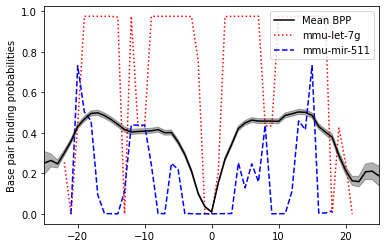

In [18]:
#plot mean, example BPPS
fig, ax = plt.subplots()

#plot example of BPP
high_mirna = 'mmu-let-7g'
low_mirna = 'mmu-mir-511'
ax.plot(data[high_mirna]['x'],
        data[high_mirna]['y'],
        color = 'red', alpha = 1,
       linestyle = ':')

ax.plot(data[low_mirna]['x'],
        data[low_mirna]['y'],
        color = 'blue', alpha = 1,
       linestyle = '--')


ax.set_ylabel('Base pair binding probabilities')
ax.fill_between(all_keys, np.array(all_means)-np.array(all_sems),
                np.array(all_means)+np.array(all_sems),
                color = 'black', alpha = 0.3)
ax.plot(all_keys, all_means,
        color = 'black', alpha = 1)

l1 = mlines.Line2D([],[], linestyle = '-', color = 'black', label = 'Mean BPP')
l2 = mlines.Line2D([], [], linestyle = ':', color = 'red', label = high_mirna)
l3 = mlines.Line2D([], [], linestyle = '--', color = 'blue', label = low_mirna)

plt.legend(handles = [l1, l2, l3], loc = 1)

ax.set_xlim(-25, 25)
plt.savefig(r'./figures/BPP.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [160]:
data[high_mirna]['x']

array([-22., -21., -20., -19., -18., -17., -16., -15., -14., -13., -12.,
       -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,
         0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.])

In [16]:
#plot miRNA structure
x_alls = []
x_lows = []
x_highs = []

y_all = np.linspace(25, 1, 25)
y_lows = np.linspace(18, 1, 18)
y_highs = np.linspace(21, 1, 21)

x_all_3p = []
x_all_5p = []
x_low_3p = []
x_low_5p = []
x_high_3p = []
x_high_5p = []

for i in tqdm(range(-25, 0, 1)):
    p3 = i
    p5 = i * -1
    
    all_ix3 = np.where(all_keys == p3)[0][0]
    all_ix5 = np.where(all_keys == p5)[0][0]
    
    width_all = (all_means[all_ix3] + all_means[all_ix5])/2
    
    x_alls.append((-1.5 + width_all, 1.5 - width_all))
    x_all_3p.append(-1.5 + width_all)
    x_all_5p.append(1.5 - width_all)
    
    if p5 <= 21:
        high_ix3 = np.where(data[high_mirna]['x'] == p3)[0][0]
        high_ix5 = np.where(data[high_mirna]['x'] == p5)[0][0]
        
        width_high = (data[high_mirna]['y'][high_ix3] + data[high_mirna]['y'][high_ix5])/2
            
        x_highs.append((-1.5 + width_high, 1.5 - width_high))
        x_high_3p.append(-1.5 + width_high)
        x_high_5p.append(1.5 - width_high)
            
    if p5 <= 18:
        low_ix3 = np.where(data[low_mirna]['x'] == p3)[0][0]
        low_ix5 = np.where(data[low_mirna]['x'] == p5)[0][0]
        
        width_low = (data[low_mirna]['y'][low_ix3] + data[low_mirna]['y'][low_ix5])/2
        
        x_lows.append((-1.5 + width_low, 1.5 -width_low))
        x_low_3p.append(-1.5 + width_low)
        x_low_5p.append(1.5 - width_low)


 16%|█▌        | 4/25 [00:00<?, ?it/s]


NameError: name 'high_mirna' is not defined

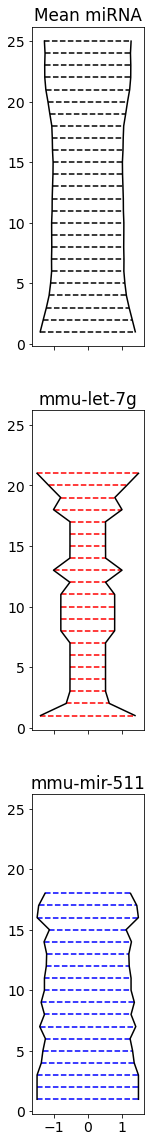

In [180]:
fig, ax = plt.subplots(3, sharey = True, sharex = True, figsize = (2, 20))

for i in range(len(x_alls)):
    ax[0].plot(x_alls[i],
               [y_all[i], y_all[i]],
               color = 'black',
               linestyle = '--')
    
    if i < len(x_highs):
        ax[1].plot(x_highs[i],
                   [y_highs[i], y_highs[i]],
                   color = 'red',
                   linestyle = '--')
        
        if i < len(x_lows):
            ax[2].plot(x_lows[i],
                       [y_lows[i], y_lows[i]],
                       color = 'blue',
                       linestyle = '--')
    
ax[0].plot(x_all_3p,
           y_all,
           color = 'black',
           linestyle = '-')
ax[0].plot(x_all_5p,
           y_all,
           color = 'black',
           linestyle = '-')
ax[0].set_title('Mean miRNA')
ax[1].plot(x_high_3p,
           y_highs,
           color = 'black',
           linestyle = '-')
ax[1].plot(x_high_5p,
           y_highs,
           color = 'black',
           linestyle = '-')
ax[1].set_title(high_mirna)
ax[2].plot(x_low_3p,
           y_lows,
           color = 'black',
           linestyle = '-')
ax[2].plot(x_low_5p,
           y_lows,
           color = 'black',
           linestyle = '-')
ax[2].set_title(low_mirna)

plt.savefig(r'./figures/example_structures.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

### Stats and plotting AUC

In [19]:
#extract aucs, fcs etc.
auc_x = []
fcs = []
exp_wt = []
exp_yac128 = []
low_bpp = {'auc': 0, 'fcs': 0, 'exp_wt': 0, 'exp_yac128': 0}
high_bpp = {'auc': 0, 'fcs': 0, 'exp_wt': 0, 'exp_yac128': 0}
there = []
for name in yac128['Systematic Name']:
    if name.lower() in auc_all:
        there.append(name.lower())
        auc_x.append(auc_all[name.lower()])
        exp_yac128.append(float(yac128['Expression level (YAC12mo)'].loc[yac128['Systematic Name'] == name]))
        exp_wt.append(float(yac128['Expression level (WT12mo)'].loc[yac128['Systematic Name'] == name]))
        fcs.append(float(yac128['Fold change (YAC12mo/WT12mo)'].loc[yac128['Systematic Name'] == name]))
        
        if name.lower() == low_mirna:
            low_bpp['auc'] = auc_all[name.lower()]
            low_bpp['exp_yac128'] = float(yac128['Expression level (YAC12mo)'].loc[yac128['Systematic Name'] == name])
            low_bpp['exp_wt'] = float(yac128['Expression level (WT12mo)'].loc[yac128['Systematic Name'] == name])
            low_bpp['fcs'] = float(yac128['Fold change (YAC12mo/WT12mo)'].loc[yac128['Systematic Name'] == name])
            
        if name.lower() == high_mirna:
            high_bpp['auc'] = auc_all[name.lower()]
            high_bpp['exp_yac128'] = float(yac128['Expression level (YAC12mo)'].loc[yac128['Systematic Name'] == name])
            high_bpp['exp_wt'] = float(yac128['Expression level (WT12mo)'].loc[yac128['Systematic Name'] == name])
            high_bpp['fcs'] = float(yac128['Fold change (YAC12mo/WT12mo)'].loc[yac128['Systematic Name'] == name])

In [ ]:
#remove big outliers in fcs
outliers = [i for i in fcs if i > 2]

In [20]:
#Least squares linear regression
auc_x = np.array(auc_x)
exp_wt = np.array(exp_wt)
exp_yac128 = np.array(exp_yac128)
fcs = np.array(fcs)

fcs_filtered = []
auc_x_filtered = []
for i in range(len(fcs)):
    if fcs[i] < 2:
        fcs_filtered.append(fcs[i])
        auc_x_filtered.append(auc_x[i])
    if fcs[i] > 2:
        print(there[i])


auc_sorted = np.sort(auc_x)

res_wt = st.linregress(auc_x, np.log10(exp_wt))
res_yac128 = st.linregress(auc_x, np.log10(exp_yac128))
res_fc = st.linregress(auc_x_filtered, fcs_filtered)

lgr_wt = res_wt.intercept + res_wt.slope * auc_sorted
lgr_yac128 = res_yac128.intercept + res_yac128.slope * auc_sorted
lgr_fc = res_fc.intercept + res_fc.slope * np.sort(np.array(auc_x_filtered))

mmu-mir-351
mmu-mir-677
mmu-mir-763


In [28]:
t = (res_wt.slope - res_yac128.slope)/np.sqrt((res_wt.stderr**2 + res_yac128.stderr**2))
print(f't = {t}\ndf = {len(exp_wt)-1}')

t = -2.7209710259226947
df = 84


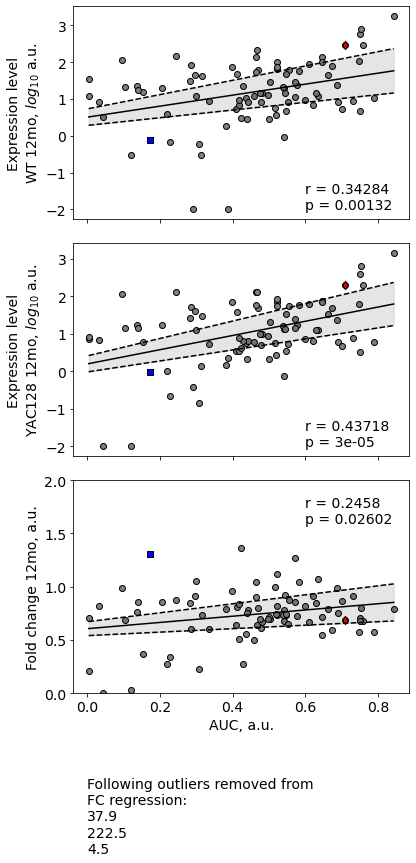

In [183]:
#plot auc against FC, expression for all mirnas
fig, ax = plt.subplots(3, sharex = True, figsize = (6,12))

plt.rc('font', size = 14)
ax[0].scatter(auc_x,
              np.log10(exp_wt),
              color = 'grey',
             edgecolor = 'black')
ax[0].plot(auc_sorted,
          lgr_wt,#pfit_wt,
          color = 'black')
ax[0].set_ylabel('Expression level\nWT 12mo, $log_{10}$ a.u.', size = 14)
ax[0].fill_between(auc_sorted,
                   (res_wt.intercept + res_wt.intercept_stderr) + (res_wt.slope + res_wt.stderr) * auc_sorted,
                   (res_wt.intercept - res_wt.intercept_stderr) + (res_wt.slope - res_wt.stderr) * auc_sorted,
                   color = 'black',
                   alpha = 0.1)
ax[0].plot(auc_sorted,
           (res_wt.intercept + res_wt.intercept_stderr) + (res_wt.slope + res_wt.stderr) * auc_sorted,
           color = 'black', linestyle = '--')
ax[0].plot(auc_sorted,
           (res_wt.intercept - res_wt.intercept_stderr) + (res_wt.slope - res_wt.stderr) * auc_sorted,
           color = 'black', linestyle = '--')

ax[0].scatter(high_bpp['auc'],
              np.log10(high_bpp['exp_wt']),
              marker = 'd',
              color = 'red', 
              edgecolor = 'black')
ax[0].scatter(low_bpp['auc'],
              np.log10(low_bpp['exp_wt']),
              marker = 's',
              color = 'blue',
              edgecolor = 'black')

ax[0].text(.6, -2, f'r = {round(res_wt.rvalue, 5)}\np = {round(res_wt.pvalue, 5)}')
        
ax[1].scatter(auc_x,
              np.log10(exp_yac128),
              color = 'grey',
             edgecolor = 'black')
ax[1].plot(auc_sorted,
           lgr_yac128,#pfit_yac128,#
           color = 'black')          
ax[1].set_ylabel('Expression level\nYAC128 12mo, $log_{10}$ a.u.', size = 14)
ax[1].fill_between(auc_sorted,
                   (res_yac128.intercept + res_yac128.intercept_stderr) + (res_yac128.slope + res_yac128.stderr) * auc_sorted,
                   (res_yac128.intercept - res_yac128.intercept_stderr) + (res_yac128.slope - res_yac128.stderr) * auc_sorted,
                   color = 'black',
                   alpha = 0.1)
ax[1].plot(auc_sorted,
           (res_yac128.intercept + res_yac128.intercept_stderr) + (res_yac128.slope + res_yac128.stderr) * auc_sorted,
           color = 'black', linestyle = '--')
ax[1].plot(auc_sorted,
           (res_yac128.intercept - res_yac128.intercept_stderr) + (res_yac128.slope - res_yac128.stderr) * auc_sorted,
           color = 'black', linestyle = '--')

ax[1].scatter(high_bpp['auc'],
              np.log10(high_bpp['exp_yac128']),
              marker = 'd',
              color = 'red', 
              edgecolor = 'black')
ax[1].scatter(low_bpp['auc'],
              np.log10(low_bpp['exp_yac128']),
              marker = 's',
              color = 'blue',
              edgecolor = 'black')
ax[1].text(.6, -2, f'r = {round(res_yac128.rvalue, 5)}\np = {round(res_yac128.pvalue, 5)}')

        
ax[2].scatter(auc_x,
              fcs,
              color = 'grey',
             edgecolor = 'black')
ax[2].plot(np.sort(np.array(auc_x_filtered)),
           lgr_fc,#pfit_fc,#
           color = 'black')
ax[2].set_ylabel('Fold change 12mo, a.u.', size = 14)
ax[2].set_xlabel('AUC, a.u.', size = 14)
ax[2].set_ylim(0,2)
ax[2].fill_between(np.sort(np.array(auc_x_filtered)),
                   (res_fc.intercept + res_fc.intercept_stderr) + (res_fc.slope + res_fc.stderr) * np.sort(np.array(auc_x_filtered)),
                   (res_fc.intercept - res_fc.intercept_stderr) + (res_fc.slope - res_fc.stderr) * np.sort(np.array(auc_x_filtered)),
                   color = 'black',
                   alpha = 0.1)
ax[2].plot(np.sort(np.array(auc_x_filtered)),
           (res_fc.intercept + res_fc.intercept_stderr) + (res_fc.slope + res_fc.stderr) * np.sort(np.array(auc_x_filtered)),
           color = 'black', linestyle = '--')
ax[2].plot(np.sort(np.array(auc_x_filtered)),
           (res_fc.intercept - res_fc.intercept_stderr) + (res_fc.slope - res_fc.stderr) * np.sort(np.array(auc_x_filtered)),
           color = 'black', linestyle = '--')
ax[2].scatter(high_bpp['auc'],
              high_bpp['fcs'],
              marker = 'd',
              color = 'red', 
              edgecolor = 'black')
ax[2].scatter(low_bpp['auc'],
              low_bpp['fcs'],
              marker = 's',
              color = 'blue',
              edgecolor = 'black')
ax[2].text(.6, 1.6, f'r = {round(res_fc.rvalue, 5)}\np = {round(res_fc.pvalue, 5)}')
ax[2].text(0, -1.5, f'Following outliers removed from\nFC regression:\n{round(outliers[0], 1)}\n{round(outliers[1], 1)}\n{round(outliers[2],1)}')
    
plt.tight_layout()

plt.savefig(r'./figures/vs-auc_lim.svg', dpi = 600, bbox_inches = 'tight')
plt.show()